Missing values:
 unnamed:_0          0
artist              0
album               0
track_name          0
track_id            0
energy              0
danceability        0
key                 0
loudness            0
acousticness        0
speechiness         0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
genre               0
dtype: int64
Duplicates: 0
Nulls in numeric columns before clipping:
 unnamed:_0          0
energy              0
danceability        0
key                 0
loudness            0
acousticness        0
speechiness         0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64
Observations: 50
Features: 17
Categorical features: ['artist', 'album', 'track_name', 'track_id', 'genre']
Numeric features: ['unnamed:_0', 'energy', 'danceability', 'key', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'te

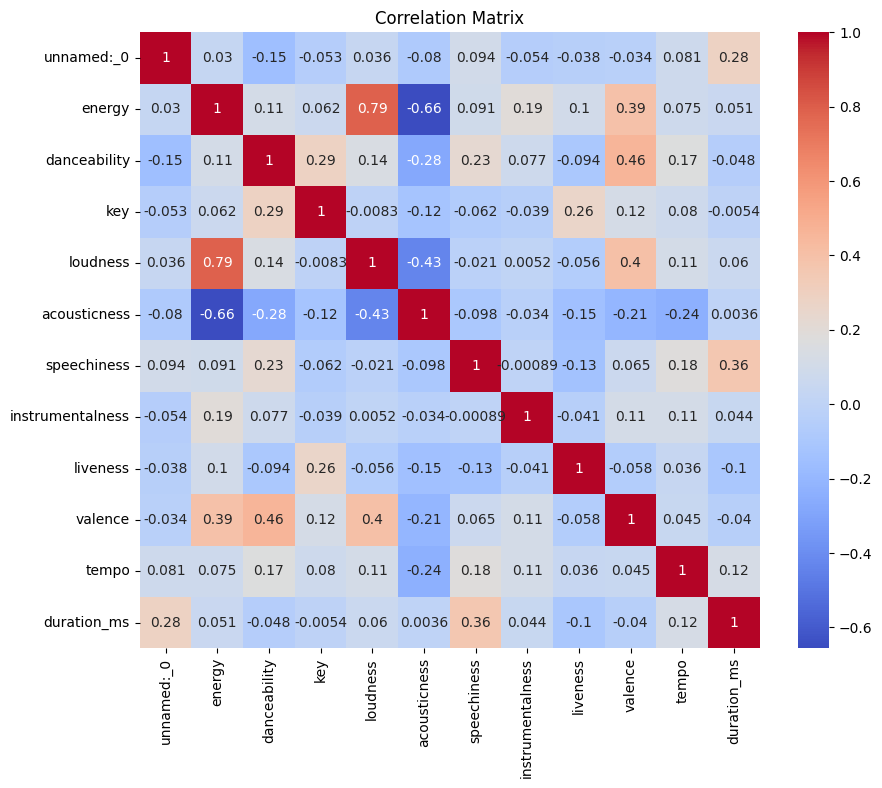

Strong positive correlations:
 energy  loudness   0.7920
dtype: float64
Strong negative correlations:
 Series([], dtype: float64)
No/little correlation (between -0.2 and 0.2):
                   unnamed:_0  energy  danceability     key  loudness  \
unnamed:_0               NaN  0.0304       -0.1540 -0.0528    0.0363   
energy                0.0304     NaN        0.1101  0.0624       NaN   
danceability         -0.1540  0.1101           NaN     NaN    0.1413   
key                  -0.0528  0.0624           NaN     NaN   -0.0083   
loudness              0.0363     NaN        0.1413 -0.0083       NaN   
acousticness         -0.0795     NaN           NaN -0.1198       NaN   
speechiness           0.0945  0.0911           NaN -0.0621   -0.0208   
instrumentalness     -0.0541  0.1926        0.0773 -0.0386    0.0052   
liveness             -0.0381  0.0998       -0.0939     NaN   -0.0564   
valence              -0.0342     NaN           NaN  0.1200       NaN   
tempo                 0.0813  0

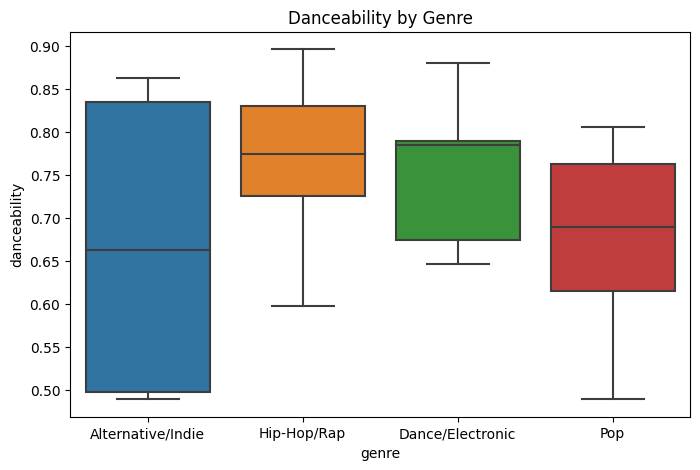

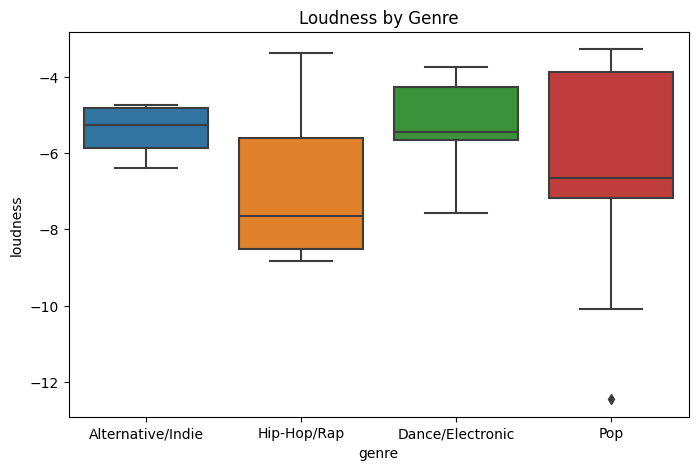

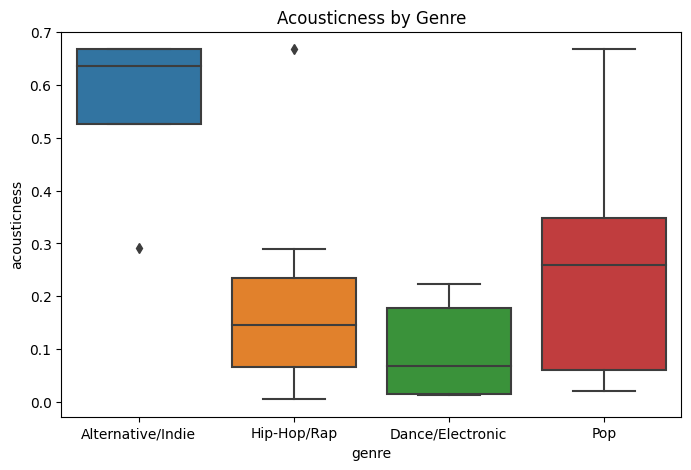

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)

# format float display for cleaner output
pd.options.display.float_format = '{:.4f}'.format

# load and clean column names
df = pd.read_csv('/kaggle/input/top-50-spotify-tracks-2020/spotifytoptracks.csv')
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# data cleaning
print("Missing values:\n", df.isnull().sum())
df = df.dropna()
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()
df = df.loc[:, ~df.columns.duplicated()]

# identify numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Nulls in numeric columns before clipping:\n", df[numeric_cols].isnull().sum())

# handle outliers in numeric columns
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    clipped = np.clip(df[col], lower, upper)
    df[col] = clipped.astype(float)
    df[col] = df[col].fillna(df[col].median())  # safety in case clipping returns NaNs

# Final cleanup for NaNs or Infs. replave ininite values and fill NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

# EDA display basic information
print("Observations:", df.shape[0])
print("Features:", df.shape[1])

cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = df.select_dtypes(include=np.number).columns.tolist()
print("Categorical features:", cat_features)
print("Numeric features:", num_features)

artist_counts = df['artist'].value_counts()
print("Artists with >1 track:\n", artist_counts[artist_counts > 1])
print("Most popular artist:", artist_counts.idxmax(), "-", artist_counts.max(), "tracks")
print("Unique artists:", df['artist'].nunique())

album_counts = df['album'].value_counts()
print("Albums with >1 track:\n", album_counts[album_counts > 1])
print("Unique albums:", df['album'].nunique())

print("Danceability > 0.7:\n", df[df['danceability'] > 0.7][['track_name', 'artist', 'danceability']])
print("Danceability < 0.4:\n", df[df['danceability'] < 0.4][['track_name', 'artist', 'danceability']])
print("Loudness > -5:\n", df[df['loudness'] > -5][['track_name', 'artist', 'loudness']])
print("Loudness < -8:\n", df[df['loudness'] < -8][['track_name', 'artist', 'loudness']])
print("Longest track:\n", df.loc[df['duration_ms'].idxmax()][['track_name', 'artist', 'duration_ms']])
print("Shortest track:\n", df.loc[df['duration_ms'].idxmin()][['track_name', 'artist', 'duration_ms']])

# genre analysis
genre_counts = df['genre'].value_counts()
print("Most popular genre:", genre_counts.idxmax())
print("Genres with one song:", genre_counts[genre_counts == 1].index.tolist())
print("Total genres:", df['genre'].nunique())

# correlation analysis
corr = df[num_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# extracting strong correlations
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
strong_pos = upper_tri[upper_tri > 0.7].stack()
strong_neg = upper_tri[upper_tri < -0.7].stack()

print("Strong positive correlations:\n", strong_pos)
print("Strong negative correlations:\n", strong_neg)
print("No/little correlation (between -0.2 and 0.2):\n", corr[(corr > -0.2) & (corr < 0.2)])

# define genres of interest for analysis
genres = ['Pop', 'Hip-Hop/Rap', 'Dance/Electronic', 'Alternative/Indie']

# print summary stats
summary = df[df['genre'].isin(genres)].groupby('genre')[['danceability', 'loudness', 'acousticness']].mean()
print("Mean values by genre:\n", summary)

# boxplots for visual comparison
for feature in ['danceability', 'loudness', 'acousticness']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='genre', y=feature, data=df[df['genre'].isin(genres)])
    plt.title(f'{feature.capitalize()} by Genre')
    plt.show()